# Evaluating SHAP

## Imports and Setup

In [1]:
import os
import platform
from pathlib import Path

# for when on NCC to be able to import local packages
os.chdir(os.path.expanduser("~/l3_project"))
Path.cwd()

PosixPath('/home2/jgcw74/l3_project')

In [3]:
import importlib

import helpers
import dataset_processing.eurosat

In [4]:
import copy

from captum.attr import DeepLiftShap
import shap

from scipy.stats import spearmanr
import foolbox

import numpy as np
import matplotlib.pyplot as plt
import einops

import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms

from safetensors.torch import load_model

In [5]:
print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe MIG 1g.10gb to use as a cuda device.
Using cuda as torch device.


In [6]:
np_rng = np.random.default_rng(42)  # for reproducibility
_ = torch.manual_seed(42)

# EuroSAT (RGB) Dataset

In [7]:
eurosat_val_ds = dataset_processing.eurosat.EuroSATRGB(split="val", image_size=224)

num_eurosat_classes = len(eurosat_val_ds.classes)

print(f"There are {len(eurosat_val_ds)} validation samples.")
print("Image dimensions and label:", eurosat_val_ds[0]["image"].size(), eurosat_val_ds[0]["label"])

There are 5400 validation samples.
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)


In [8]:
val_dataloader = torch.utils.data.DataLoader(
    eurosat_val_ds, batch_size=32, num_workers=4, shuffle=False, drop_last=False
)
validation_iterator = iter(dataset_processing.core.cycle(val_dataloader))

## ResNet 50

### Load Model

In [9]:
checkpoints_path = Path.cwd() / 'checkpoints'
assert checkpoints_path.exists()

In [10]:
all_resnet50_saved = list(checkpoints_path.glob('./resnet50/*.st'))
# print(all_resnet50_saved)
latest_resnet50_path = max(all_resnet50_saved, key=os.path.getctime)
latest_resnet50_path

PosixPath('/home2/jgcw74/l3_project/checkpoints/resnet50/FineTunedResNet50_final_ft_weights(0.989).st')

In [11]:
resnet50 = helpers.models.FineTunedResNet50(pretrained=False, n_input_bands=3, n_output_classes=num_eurosat_classes).to(
    device)

In [12]:
print('Missing/Unexpected keys:', load_model(resnet50, latest_resnet50_path))
_ = resnet50.eval()  # turn off randomisation in batchnorm layers, etc.

Missing/Unexpected keys: (set(), [])


#### Confirm model accuracy

In [ ]:
check_acc = False
if check_acc:
    _, acc = helpers.ml.validation_step(
        resnet50, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
    )
    assert acc > 0.98
    print("Validation accuracy", acc)

### Select images to explain

In [13]:
idxs_to_explain = np_rng.integers(0, len(eurosat_val_ds), 5)
imgs_to_explain = torch.stack([eurosat_val_ds[i]["image"] for i in idxs_to_explain]).to(device)
true_labels = [eurosat_val_ds[i]["label"] for i in idxs_to_explain]

blurred_imgs = transforms.functional.gaussian_blur_image(imgs_to_explain, kernel_size=21, sigma=10)
black_imgs = torch.zeros_like(imgs_to_explain) - 1
# Black background as in https://dl.acm.org/doi/abs/10.1145/3331184.3331312
# Blurred as in https://www.sciencedirect.com/science/article/pii/S0303243421002270

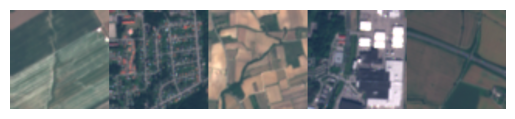

In [14]:
helpers.plotting.show_image(
    einops.rearrange(imgs_to_explain, "(b1 b2) c h w -> c (b1 h) (b2 w)", b2=len(idxs_to_explain)))

[tensor(0), tensor(7), tensor(6), tensor(4), tensor(3)]


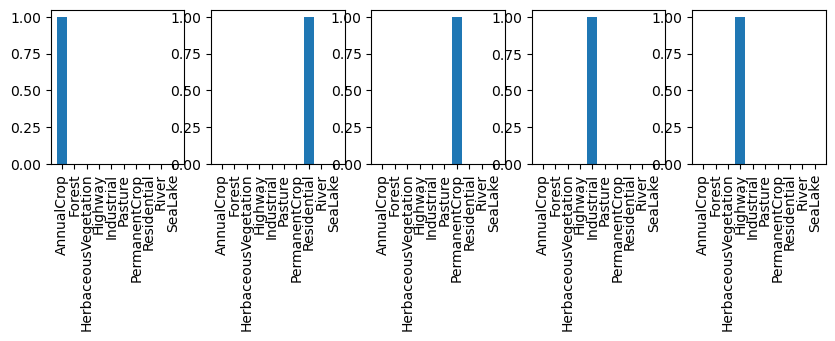

In [15]:
preds = resnet50(imgs_to_explain)
preds = torch.softmax(preds, dim=-1).cpu().detach().numpy()
_, axs = plt.subplots(1, len(idxs_to_explain), figsize=(2 * len(idxs_to_explain), 2))
for i in range(len(idxs_to_explain)):
    ax: plt.Axes = axs[i]
    ax.bar(eurosat_val_ds.classes, preds[i])
    # rotate x ticks for axis
    ax.tick_params(axis='x', rotation=90)
print(true_labels)

In [16]:
random_bg_imgs = torch.stack([eurosat_val_ds[i]["image"] for i in np_rng.integers(0, len(eurosat_val_ds), 100)]).to(
    device)

In [17]:
random_blurred_bg_imgs = transforms.functional.gaussian_blur_image(
    random_bg_imgs, kernel_size=15, sigma=10
).to(device)

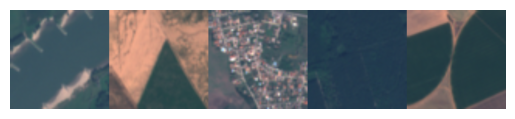

In [18]:
helpers.plotting.show_image(
    einops.rearrange(random_bg_imgs[:5], "(b1 b2) c h w -> c (b1 h) (b2 w)", b2=len(idxs_to_explain)))

### Set up/Experiment with SHAP

#### Captum DeepLiftShap

In [ ]:
deep_shap_explainer = DeepLiftShap(resnet50, multiply_by_inputs=True)  # True for global attribution

In [ ]:
captum_shap_vals = helpers.xai.calculate_shap_values_tensor(imgs_to_explain, blurred_imgs, deep_shap_explainer,
                                                            num_eurosat_classes)

In [ ]:
n = 5
shap.image_plot(
    helpers.xai.prepare_shap_for_image_plot(captum_shap_vals[:, :n]),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
)

##### Pooled SHAP values

In [ ]:
pool_size = 16
pooled_captum_shap_vals = (pool_size ** 2) * nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)(
    captum_shap_vals.flatten(0, 1)
).repeat_interleave(pool_size, dim=-2).repeat_interleave(pool_size, dim=-1)
pooled_captum_shap_vals = torch.unflatten(pooled_captum_shap_vals, 0, (num_eurosat_classes, -1))

In [ ]:
n = 5
shap.image_plot(
    helpers.xai.prepare_shap_for_image_plot(pooled_captum_shap_vals[:, :n]),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
)

In [ ]:
captum_random_bg_shap_vals = helpers.xai.calculate_shap_values_tensor(imgs_to_explain, random_bg_imgs[:25],
                                                                      deep_shap_explainer, num_eurosat_classes)

n = 5
shap.image_plot(
    helpers.xai.prepare_shap_for_image_plot(captum_random_bg_shap_vals[:, :n]),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
    hspace=0.3,
)

#### Original SHAP library

In [ ]:
def predict_fn(np_imgs: np.ndarray):
    model_input_img = einops.rearrange(torch.from_numpy(np_imgs * 2) - 1, "b h w c -> b c h w").to(device)
    model_output: torch.Tensor = resnet50(model_input_img)
    # softmax_output = torch.softmax(model_output, dim=-1)
    return model_output.cpu().detach().numpy()

In [ ]:
np01_imgs_to_explain = einops.rearrange((imgs_to_explain + 1) / 2, "b c h w -> b h w c").cpu().numpy()

##### Partition Explainer

Following regime in https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

In [ ]:
blur_masker = shap.maskers.Image("blur(128,128)", np01_imgs_to_explain[0].shape)
partition_explainer = shap.PartitionExplainer(predict_fn, blur_masker, output_names=eurosat_val_ds.classes)

In [ ]:
partition_shap_vals = partition_explainer(
    np01_imgs_to_explain,
    max_evals=10000,
    batch_size=128,
    outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)

In [ ]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition_shap_vals.values, -1, 0)],
    pixel_values=((partition_shap_vals.data + 1) / 2),
    labels=np.vectorize(lambda x: x[:5])(partition_shap_vals.output_names),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    show=False,
)
_ = plt.gcf().suptitle(f"{partition_explainer.__class__.__name__} - {blur_masker.mask_value}")

###### Using 0 masker

In [ ]:
masker = shap.maskers.Image(0, np01_imgs_to_explain[0].shape)  # fill with zeros rather than blurring
partition0_explainer = shap.PartitionExplainer(predict_fn, masker, output_names=eurosat_val_ds.classes)
partition0_shap_vals = partition0_explainer(
    np01_imgs_to_explain[:2],
    max_evals=10000,
    batch_size=128,
    outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition0_shap_vals.values, -1, 0)],
    pixel_values=((partition0_shap_vals.data + 1) / 2),
    labels=np.vectorize(lambda x: x[:5])(partition0_shap_vals.output_names),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=False,
)
_ = plt.gcf().suptitle(f"{partition_explainer.__class__.__name__} - {masker.mask_value}")

##### Deep Explainer (broken?)

Following regime in https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

In [ ]:
deep_explainer = shap.DeepExplainer(resnet50, random_bg_imgs[:50])

Requires a lot of GPU memory - 50 background images requires 17.3GB of GPU memory/VRAM

In [ ]:
# additivity check fails - implementation bug on my or shap's end...?
deep_shap_vals = deep_explainer.shap_values(imgs_to_explain[:2], check_additivity=False)
deep_shap_vals = einops.rearrange(deep_shap_vals, "b c h w l -> l b c h w")

In [ ]:
shap.image_plot(
    list(einops.rearrange(deep_shap_vals, "l b c h w -> l b h w c")),
    pixel_values=einops.rearrange((imgs_to_explain[:2] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=(np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain[:2].shape[0], 1))),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=True,
)

In [ ]:
pool_size = 16
pooled_deep_shap_vals = (pool_size ** 2) * nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)(
    torch.from_numpy(deep_shap_vals).flatten(0, 1)).repeat_interleave(pool_size, dim=-2).repeat_interleave(pool_size,
                                                                                                           dim=-1)
pooled_deep_shap_vals = torch.unflatten(pooled_deep_shap_vals, 0, (num_eurosat_classes, -1))

In [ ]:
shap.image_plot(
    list(einops.rearrange(pooled_deep_shap_vals, "l b c h w -> l b h w c")),
    pixel_values=einops.rearrange((imgs_to_explain[:2] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=(np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain[:2].shape[0], 1))),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=True,
)

###### Trying to debug the additivity of DeepExplainer...

In [ ]:
class ResNet50Wrapper(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model.eval()
        self.output = nn.Softmax(dim=-1)

    def forward(self, x):
        return self.output(self.model(x))


wrapped_resnet50 = ResNet50Wrapper(resnet50)

In [ ]:
e = shap.DeepExplainer(wrapped_resnet50, random_bg_imgs[:50])
# s = e.shap_values(imgs_to_explain[:2], check_additivity=True)

In [ ]:
imgs_to_explain.min(), imgs_to_explain.max(), random_bg_imgs.min(), random_bg_imgs.max()

In [ ]:
# Use a simpler model for testing
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(16 * 224 * 224, num_eurosat_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


simple_model = SimpleModel().to(device)

e = shap.DeepExplainer(simple_model, random_bg_imgs[:50])
# s = e.shap_values(imgs_to_explain[:2], check_additivity=True)

### Evaluate SHAP

In [ ]:
randomised_model = copy.deepcopy(resnet50).to(device)
helpers.evaluate_xai.reset_child_params(randomised_model)
_ = randomised_model.eval()

In [ ]:
if check_acc:
    _, og_acc = helpers.ml.validation_step(
        resnet50, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
    )
    _, random_acc = helpers.ml.validation_step(
        randomised_model, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
    )
    print(f"Original/Randomised accuracy on validation set: {og_acc:.4f}/{random_acc:.4f}")

##### Calculate Final Values

###### Calculate Captum SHAP values

⚠️ Requires ~18GB of GPU memory (VRAM)

In [ ]:
og_shap_e = DeepLiftShap(resnet50, multiply_by_inputs=True)
random_shap_e = DeepLiftShap(randomised_model, multiply_by_inputs=True)

In [ ]:
og_shap_values = helpers.xai.calculate_shap_values_tensor(imgs_to_explain, blurred_imgs, og_shap_e, num_eurosat_classes)
random_shap_values = helpers.xai.calculate_shap_values_tensor(imgs_to_explain, blurred_imgs, random_shap_e,
                                                              num_eurosat_classes)

In [ ]:
n = 5
shap.image_plot(
    helpers.xai.prepare_shap_for_image_plot(og_shap_values[:, :n]),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
)

In [ ]:
n = 5
shap.image_plot(
    helpers.xai.prepare_shap_for_image_plot(random_shap_values[:, :n]),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
)

###### Calculate Partition SHAP values


In [ ]:
from functools import partial

In [ ]:
np01_imgs_to_explain = einops.rearrange((imgs_to_explain + 1) / 2, "b c h w -> b h w c").cpu().numpy()

In [ ]:
def predict_fn(np_imgs: np.ndarray, model: nn.Module = None):
    model_input_img = einops.rearrange(torch.from_numpy(np_imgs * 2) - 1, "b h w c -> b c h w").to(device)
    model_output: torch.Tensor = model(model_input_img)
    # softmax_output = torch.softmax(model_output, dim=-1)
    return model_output.cpu().detach().numpy()

In [ ]:
blur_masker = shap.maskers.Image("blur(128,128)", np01_imgs_to_explain[0].shape)
og_partition_e = shap.PartitionExplainer(partial(predict_fn, model=resnet50), blur_masker,
                                         output_names=eurosat_val_ds.classes)

In [ ]:
random_partition_e = shap.PartitionExplainer(partial(predict_fn, model=randomised_model), blur_masker,
                                             output_names=eurosat_val_ds.classes)

⚠️ Also requires a lot of memory for high batch sizes!

For `max_evals=10000` and `batch_size=64`, requires approx 6GB.

In [ ]:
partition_og_shap = og_partition_e(
    np01_imgs_to_explain,
    max_evals=10000,
    batch_size=64,  # batch_size=5 takes 4m 21s/=32 takes 3m40s/=64 takes 3m34s
    # outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)
partition_random_shap = random_partition_e(
    np01_imgs_to_explain,
    max_evals=10000,
    batch_size=64,
    # outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)

In [ ]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition_og_shap.values, -1, 0)],
    pixel_values=((partition_og_shap.data + 1) / 2),
    labels=np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain.shape[0], 1)),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    hspace="auto",
    show=False,
)
# _ = plt.gcf().suptitle(f"{og_partition_e.__class__.__name__} - {blur_masker.mask_value}")

In [ ]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition_random_shap.values, -1, 0)],
    pixel_values=((partition_random_shap.data + 1) / 2),
    labels=np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain.shape[0], 1)),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    hspace="auto",
    show=False,
)
# _ = plt.gcf().suptitle(f"{random_partition_e.__class__.__name__} - {blur_masker.mask_value}")

#### Save/Load SHAP values

In [19]:
output_path = Path.cwd() / "output"

In [ ]:
# partition_og_shap_values = partition_og_shap.values
# partition_random_shap_values = partition_random_shap.values
# if isinstance(og_shap_values, torch.Tensor):
#     og_shap_values = og_shap_values.cpu()
#     random_shap_values = random_shap_values.cpu()
#
# np.savez_compressed(output_path / "resnet50_shap_vals.npz",
#                     og_shap_values=og_shap_values,
#                     random_shap_values=random_shap_values,
#                     partition_og_shap_values=partition_og_shap_values,
#                     partition_random_shap_values=partition_random_shap_values)

In [20]:
with np.load(output_path / "resnet50_shap_vals.npz") as data:
    og_shap_values = data["og_shap_values"]
    random_shap_values = data["random_shap_values"]
    partition_og_shap_values = data["partition_og_shap_values"]
    partition_random_shap_values = data["partition_random_shap_values"]

In [21]:
partition_og_shap_values.shape

(5, 224, 224, 3, 10)

#### Correctness: Parameter Randomisation

##### Calculate Difference (the actual evaluation)

In [ ]:
print(eurosat_val_ds.classes)

In [ ]:
# partition_og_shap_values.values.shape, np.array(helpers.xai.prepare_shap_for_image_plot(og_shap_values)).transpose(1, 0, 2, 3, 4).shape

In [ ]:
s1 = einops.rearrange(og_shap_values, "l b c h w -> b h w c l")
s2 = einops.rearrange(random_shap_values, "l b c h w -> b h w c l")

helpers.similarity_metrics.pixel_l2_distance_per_label(s1, s2)

In [ ]:
randomised_l2_df = helpers.similarity_metrics.make_l2_distance_per_label_df(
    eurosat_val_ds.classes, partition_og_shap_values, partition_random_shap_values, normalise=True)
randomised_l2_df

In [ ]:
randomised_l2_df.plot(kind="bar", xlabel="class", ylabel="L2 distance",
                      title="L2 distance between randomised and true model's shap values")

#### Correctness: Incremental Deletion

In [ ]:
partition_shap_vals = einops.rearrange(partition_og_shap_values, "b h w c l -> b l h w c")
partition_shap_vals.shape

In [ ]:
shap_importance_rank = helpers.utils.rank_pixel_importance(partition_shap_vals.sum(-1))

In [ ]:
i = 4  # selected image for testing
true_label_text = eurosat_val_ds.classes[int(true_labels[i])]
helpers.plotting.visualise_importance(
    imgs_to_explain[i], shap_importance_rank[i][int(true_labels[i])]
)
plt.show()

##### Deletion/Infilling

###### By importance

In [ ]:
num_del_iterations = 30
iterative_deletions, k_values = helpers.evaluate_xai.incrementally_delete(imgs_to_explain[i].cpu().numpy(),
                                                                          shap_importance_rank[i][int(true_labels[i])],
                                                                          num_del_iterations,
                                                                          "shuffle")  # Nearest neighbour deletion as in I. Kakogeorgiou and K. Karantzalos
iterative_deletions = np.squeeze(
    iterative_deletions)  # remove singleton dim (there is only 1 trial when importance_rank is specified)
helpers.plotting.show_image(einops.rearrange(iterative_deletions[::5], "p c h w -> c h (p w)"))
plt.show()
# helpers.plotting.show_image(einops.rearrange(iterative_deletions[-3:], "p c h w -> c h (p w)"))
# plt.show()

In [ ]:
df = helpers.evaluate_xai.make_preds_df(resnet50, iterative_deletions, columns=eurosat_val_ds.classes, max_batch_size=4)

In [ ]:
# df.plot(kind="bar", stacked=False, grid=True, rot=45, figsize=(15, 5),
#         title="Change in predictions with incremental deletion")
df.plot(kind="line", xlabel="iterations", rot=45, xlim=(0, num_del_iterations),
        y=true_label_text,
        ylabel="confidence", ylim=(0, 1),
        grid=True,
        title="Effect of deletions on correct class prediction confidence")

###### Randomised

In [ ]:
num_rand_trials = 10
random_deletions, k_values = helpers.evaluate_xai.incrementally_delete(imgs_to_explain[i].cpu().numpy(),
                                                                       (16, None, num_rand_trials),
                                                                       num_del_iterations, "nn")

helpers.plotting.show_image(einops.rearrange(random_deletions[::5, 0], "p c h w -> c h (p w)"))

In [ ]:
flatted_random_deletions = random_deletions.reshape(-1, *random_deletions.shape[2:])  # combine iterations and trials
flatted_random_deletions.shape

In [ ]:
rand_df = helpers.evaluate_xai.make_preds_df(resnet50, flatted_random_deletions, columns=eurosat_val_ds.classes,
                                             max_batch_size=5)
rand_df = rand_df.groupby(np.arange(len(rand_df)) // num_rand_trials).mean()

##### Area under curve calculation

In [ ]:
importlib.reload(helpers.plotting)
helpers.plotting.make_deletions_plot(df, rand_df, return_aucs=True,
                                     method_names=["cam", "random"], plot_class=true_label_text,
                                     plt_title="Effect of deletions on confidence of correct class prediction")

#### Output-completeness
Preservation/Deletion check

In [ ]:
deletion_threshold = 0.1  # "All important features"
img = imgs_to_explain[i].cpu().numpy()
num_pixels = img.shape[-2] * img.shape[-1]

##### Deletion

In [ ]:
deleted = helpers.evaluate_xai.delete_top_k_important(img, shap_importance_rank[i][int(true_labels[i])],
                                                      deletion_threshold * num_pixels, "nn")
helpers.plotting.show_image(deleted)

In [ ]:
random_deleted_images = []
for _ in range(num_rand_trials):
    random_deleted_images.append(
        helpers.evaluate_xai.delete_top_k_important(img, (16, np_rng), deletion_threshold * num_pixels, "nn")
    )
random_deleted_images = np.array(random_deleted_images)
# helpers.plotting.show_image(deleted)

In [ ]:
importlib.reload(helpers.evaluate_xai)
random_deletion_check_df = helpers.evaluate_xai.make_preds_df(
    resnet50, random_deleted_images, columns=eurosat_val_ds.classes, max_batch_size=5
)
random_deletion_acc = random_deletion_check_df[true_label_text].mean()
random_deletion_acc

In [ ]:
org_acc, del_acc = resnet50(
    torch.from_numpy(np.stack([img, deleted])).to(device)
).detach().cpu().softmax(-1)[:, int(true_labels[i])]
org_acc, del_acc

In [ ]:
# drop in acc vs random = (rand_del_acc - org_acc) - (del_acc - org_acc) = rand_del_acc - del_acc
print("Deletion check (↑, 1 best):",
      random_deletion_acc - del_acc.item())  # we want del_acc to be low for a good explanation

##### Preservation (inverse of deletion)

In [ ]:
inverted_rank = helpers.utils.rank_pixel_importance(shap_importance_rank[i][int(true_labels[i])])
preserved = helpers.evaluate_xai.delete_top_k_important(img, inverted_rank, (1 - deletion_threshold) * num_pixels, "nn")
helpers.plotting.show_image(preserved)

In [ ]:
random_preserved_images = []
for _ in range(num_rand_trials):
    random_preserved_images.append(
        helpers.evaluate_xai.delete_top_k_important(img, (16, np_rng), (1 - deletion_threshold) * num_pixels, "nn")
    )
random_preserved_images = np.array(random_preserved_images)
# helpers.plotting.show_image(random_preserved_images[0])

In [ ]:
random_preservation_check_df = helpers.evaluate_xai.make_preds_df(
    resnet50, random_preserved_images, columns=eurosat_val_ds.classes, max_batch_size=5
)
random_preservation_acc = random_preservation_check_df[true_label_text].mean()
random_preservation_acc

In [ ]:
org_acc, pres_acc = resnet50(
    torch.from_numpy(np.stack([img, preserved])).to(device)
).detach().cpu().softmax(-1)[:, int(true_labels[i])]
org_acc, pres_acc

In [ ]:
# drop in acc vs random = 1 + (rand_pres_acc - org_acc) - (pres_acc - org_acc) = 1 + rand_pres_acc - pres_acc
print("Preservation check (↓, 0 best):",
      1 + random_preservation_acc - pres_acc.item())  # we want pres_acc to be high for a good explanation

#### Continuity: Perturbation sensitivity

##### Add noise and check pred impact

In [ ]:
perturb_degree = 0.15

In [ ]:
noisy_samples = helpers.evaluate_xai.perturb(imgs_to_explain, perturb_degree)

helpers.plotting.show_image(noisy_samples)

###### Generate new explanations on perturbed images

In [ ]:
np01_noisy_samples = einops.rearrange((noisy_samples + 1) / 2, "b c h w -> b h w c").cpu().numpy()
partition_og_shap_noisy_samples = og_partition_e(
    np01_noisy_samples,
    max_evals=10000,
    batch_size=64,
)

In [ ]:
# partition_og_shap_noisy_samples_values = partition_og_shap_noisy_samples.values
# np.savez_compressed(output_path / f"resnet50_noisy{perturb_degree:.2f}_shap_vals.npz",
#                     partition_og_shap_noisy_samples_values=partition_og_shap_noisy_samples_values,
#                     images=np01_noisy_samples,
#                     )

In [ ]:
with np.load(output_path / f"resnet50_noisy{perturb_degree:.2f}_shap_vals.npz") as data:
    partition_og_shap_noisy_samples_values = data["partition_og_shap_noisy_samples_values"]
    np01_noisy_samples = data["images"]
    noisy_samples = torch.from_numpy(einops.rearrange((np01_noisy_samples * 2) - 1, "b h w c -> b c h w"))

helpers.plotting.show_image(np01_noisy_samples)

In [ ]:
pred_change_df = helpers.evaluate_xai.pred_change_df(resnet50, imgs_to_explain, noisy_samples, 5)
pred_change_df

In [ ]:
same_idxs = pred_change_df.index[pred_change_df['original_pred'] == pred_change_df['perturbed_pred']]
same_idxs

In [ ]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition_og_shap_values, -1, 0)],
    pixel_values=((np01_imgs_to_explain + 1) / 2),
    labels=np.tile([x[:5] for x in eurosat_val_ds.classes], (np01_imgs_to_explain.shape[0], 1)),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    hspace="auto",
    show=False,
)
print("SHAP values for original image")

In [ ]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition_og_shap_noisy_samples_values, -1, 0)],
    pixel_values=((np01_noisy_samples + 1) / 2),
    labels=np.tile([x[:5] for x in eurosat_val_ds.classes], (np01_noisy_samples.shape[0], 1)),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    hspace="auto",
    show=False,
)
print("SHAP values for perturbed image")

##### L2 distance to quantify change

In [ ]:
og_s = partition_og_shap_values[same_idxs]
random_s = partition_random_shap_values[same_idxs]
noise_s = partition_og_shap_noisy_samples_values[same_idxs]

randomised_l2_df = helpers.similarity_metrics.make_l2_distance_per_label_df(
    eurosat_val_ds.classes, og_s, random_s, normalise=True)
continuity_l2_df = helpers.similarity_metrics.make_l2_distance_per_label_df(
    eurosat_val_ds.classes, og_s, noise_s, normalise=True)
randomised_l2_df.join(continuity_l2_df, lsuffix=" (to randomised)", rsuffix=" (to noisy)").plot(kind="bar")

###### Not normalised version (same explanation type)

In [ ]:
l2_to_random_no_norm_df = helpers.similarity_metrics.make_l2_distance_per_label_df(
    eurosat_val_ds.classes, og_s, random_s, normalise=False)
l2_to_noisy_no_norm_df = helpers.similarity_metrics.make_l2_distance_per_label_df(
    eurosat_val_ds.classes, og_s, noise_s, normalise=False)

l2_to_random_no_norm_df.join(l2_to_noisy_no_norm_df, lsuffix=" (to randomised)", rsuffix=" (to noisy)").plot(kind="bar")

###### Distance of prediction labels only

In [ ]:
original_labels = pred_change_df[pred_change_df['original_pred'] == pred_change_df['perturbed_pred']][
    'original_pred'].tolist()
extracted_noisy = partition_og_shap_noisy_samples_values[same_idxs, ..., original_labels][..., np.newaxis]
extracted_og = partition_og_shap_values[same_idxs, ..., original_labels][..., np.newaxis]
extracted_random = partition_random_shap_values[same_idxs, ..., original_labels][..., np.newaxis]
extracted_noisy.shape, extracted_og.shape

In [ ]:
helpers.similarity_metrics.make_l2_distance_per_label_df(
    ["Prediction"], extracted_og, extracted_noisy, normalise=False)

In [ ]:
helpers.similarity_metrics.make_l2_distance_per_label_df(
    ["Prediction"], extracted_og, extracted_random, normalise=False)

##### Compare rankings?

In [ ]:
og_ranked = helpers.utils.rank_pixel_importance(extracted_og[:, :, :, 0].sum(-1))
noisy_ranked = helpers.utils.rank_pixel_importance(extracted_noisy[:, :, :, 0].sum(-1))

In [ ]:
plt.matshow(np.hstack([og_ranked[0], np.zeros((224, 50)), noisy_ranked[0]]), cmap="plasma_r")

In [ ]:
average_scc = helpers.similarity_metrics.spearman_rank(
    og_ranked, noisy_ranked, show_plot=True
).mean()

In [ ]:
plt.matshow(np.hstack([og_ranked[2], np.zeros((224, 10)), noisy_ranked[2]]), cmap="plasma_r")

A higher SCC statistic indicates that the rankings agree with each other more, i.e. that the relative ranking of pixels didn't change from original image to perturbed version.

In [ ]:
print(f"Average SCC (where model prediction hasn't changed) (↑, 1 best): {average_scc:.4f}")

###### Compared to uncorrelated

As a comparison, for e.g. index 1 image, the prediction changed from class 7 to class 0 so the rankings are very unrelated to each other.

In [ ]:
temp1 = partition_og_shap_values[[1, 4], ..., [7, 3]]
temp2 = partition_og_shap_noisy_samples_values[[1, 4], ..., [0, 7]]
temp1.shape

In [ ]:
temp1_rank = helpers.utils.rank_pixel_importance(temp1.sum(-1))[0].flatten()
temp2_rank = helpers.utils.rank_pixel_importance(temp2.sum(-1))[0].flatten()

plt.title(f"SCC={spearmanr(temp1_rank, temp2_rank).statistic:.3f}")
plt.scatter(temp1_rank, temp2_rank)
plt.plot(range(temp1_rank.max()), "r--", label="SCC$=+1$")
plt.plot(range(temp1_rank.max(), 0, -1), "y--", label="SCC$=-1$")
plt.legend()
plt.show()

##### Compare top-k intersection?

In [ ]:
intersections = helpers.similarity_metrics.top_k_intersection(og_ranked, noisy_ranked, 5000)

In [ ]:
print([f"{i:.4f}" for i in intersections])
print(f"Average intersection percentage of top {5000} "
      f"(where model prediction hasn't changed) (↑, 1 best): {intersections.mean():.4f}")

##### SSIM

In [ ]:
ssims = helpers.similarity_metrics.structural_similarity(og_ranked, noisy_ranked)

In [ ]:
print(f"Average SSIM value betweens explanations (↑, 1 best): {ssims.mean():.4f}")

Return all these metrics when formalising - allows choice by end user

#### Contrastivity: Adversarial Attack

##### Generate Adversarial Examples

In [ ]:
fmodel = foolbox.PyTorchModel(resnet50, bounds=(-1, 1))

In [ ]:
attack = foolbox.attacks.LinfDeepFoolAttack()
# fooling_criteria = foolbox.criteria.TargetedMisclassification(((torch.stack(true_labels)+1)%num_eurosat_classes).to(device))
fooling_criteria = foolbox.criteria.Misclassification(torch.stack(true_labels).to(device))
# epsilons = np.linspace(0.01, 1, num=20)
adversarial_imgs, clipped, is_adv = attack(fmodel, imgs_to_explain, fooling_criteria, epsilons=0.01)
helpers.plotting.show_image(adversarial_imgs)

In [ ]:
preds = resnet50(imgs_to_explain)
preds = torch.softmax(preds, dim=-1).cpu().detach().numpy()
_, axs = plt.subplots(1, len(idxs_to_explain), figsize=(2 * len(idxs_to_explain), 2))
for i in range(len(idxs_to_explain)):
    ax: plt.Axes = axs[i]
    ax.bar(eurosat_val_ds.classes, preds[i])
    # rotate x ticks for axis
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0, 1])

In [ ]:
preds = resnet50(adversarial_imgs)
preds = torch.softmax(preds, dim=-1).cpu().detach().numpy()
_, axs = plt.subplots(1, len(idxs_to_explain), figsize=(2 * len(idxs_to_explain), 2))
for i in range(len(idxs_to_explain)):
    ax: plt.Axes = axs[i]
    ax.bar(eurosat_val_ds.classes, preds[i])
    # rotate x ticks for axis
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0, 1])

##### Generate explanations on adversarial examples

In [ ]:
np01_adversarial_samples = einops.rearrange((adversarial_imgs + 1) / 2, "b c h w -> b h w c").cpu().numpy()
partition_og_shap_adversarial_samples = og_partition_e(
    np01_adversarial_samples,
    max_evals=10000,
    batch_size=64,
)

In [ ]:
partition_og_shap_adversarial_samples_values = partition_og_shap_adversarial_samples.values
# np.savez_compressed(output_path / f"resnet50_adv_shap_vals.npz",
#                     partition_og_shap_noisy_samples_values=partition_og_shap_adversarial_samples_values,
#                     images=np01_adversarial_samples,
#                     )

In [ ]:
with np.load(output_path / f"resnet50_adv_shap_vals.npz") as data:
    partition_og_shap_noisy_samples_values = data["partition_og_shap_noisy_samples_values"]
    np01_adversarial_samples = data["images"]
    adversarial_imgs = torch.from_numpy(einops.rearrange((np01_adversarial_samples * 2) - 1, "b h w c -> b c h w"))

In [ ]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition_og_shap_adversarial_samples_values, -1, 0)],
    pixel_values=((np01_adversarial_samples + 1) / 2),
    labels=np.tile([x[:5] for x in eurosat_val_ds.classes], (np01_adversarial_samples.shape[0], 1)),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    hspace="auto",
    show=False,
)
print("SHAP values for adversarial image")

##### Compare explanations and generate metrics

In [ ]:
original_idxs = resnet50(imgs_to_explain.to(device)).softmax(-1).argmax(-1).cpu().detach().numpy()
attacked_idxs = resnet50(adversarial_imgs.to(device)).softmax(-1).argmax(-1).cpu().detach().numpy()
original_idxs, attacked_idxs

In [ ]:
og_explanations = partition_og_shap_values[range(len(original_idxs)), ..., original_idxs]
adv_explanations = partition_og_shap_adversarial_samples_values[range(
    len(attacked_idxs)), ..., attacked_idxs]  # for SHAP values, the selected explanations changes since the output class has changed
og_explanations.shape

In [ ]:
og_rankings = helpers.utils.rank_pixel_importance(og_explanations.sum(-1))
adv_rankings = helpers.utils.rank_pixel_importance(adv_explanations.sum(-1))

In [ ]:
plt.matshow(np.hstack([og_rankings[-1], adv_rankings[-1]]), cmap="plasma_r")

In [ ]:
helpers.similarity_metrics.spearman_rank(og_rankings,
                                         adv_rankings)  # lower better now - we want the explanations to have changed a lot

In [ ]:
helpers.similarity_metrics.top_k_intersection(og_rankings, adv_rankings)  # lower better

In [ ]:
helpers.similarity_metrics.structural_similarity(og_rankings, adv_rankings)  # lower better

#### Compactness

In [ ]:
og_shap_abs = np.abs(
    og_explanations.sum(-1))  # sum over colour channels; negative parts of the explanation also contribute to clutter
og_shap_abs /= og_shap_abs.max(axis=(1, 2), keepdims=True)  # normalise each image/row
og_shap_abs.shape

In [ ]:
plt.matshow(og_shap_abs[-1], cmap="plasma")

In [ ]:
over_half_activated = np.sum(og_shap_abs > 0.5, axis=(1, 2)) / og_shap_abs[0].size
over_half_activated

In [ ]:
over_q3_activated = np.sum(og_shap_abs > 0.75, axis=(1, 2)) / og_shap_abs[0].size
over_q3_activated

In [ ]:
helpers.evaluate_xai.compactness(og_shap_abs, 0.75)